In [1]:
import os, sys, io
import multiprocessing as mp
import numpy as np
import osmnx as ox
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display #, IFrame
import folium
from pyproj import CRS
from PIL import Image
import selenium

def load_src(name, fpath):
    import os, imp
    p = fpath if os.path.isabs(fpath) \
        else os.path.join(os.path.dirname(os.path.abspath('')), fpath)
    return imp.load_source(name, p)
load_src("utils", "utils/__init__.py")
import utils

%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.2'

In [2]:
# conda install -c conda-forge geckodriver
# conda install -c conda-forge selenium

In [3]:
ftiles = ['OpenStreetMap','Stamen Terrain','Stamen Toner','Mapbox Bright','Mapbox Control Room']
data_path = '../../data'
crs = CRS("EPSG:4326") # WGS84 format
porto_lat = 41.1496100
porto_lon = -8.6109900

In [4]:
REMOVE_DUPLICATED_POINTS_IN_TRAJECTORIES = False
SAVE_IMAGES = True
PLOT_LINES = True

## Taxi Trajectories

Each data sample corresponds to one completed trip. It contains a total of
9 (nine) features, described as follows:
1. TRIP_ID: (String) It contains an unique identifier for each trip;
2. CALL_TYPE: (char) It identifies the way used to demand this service. It may contain one of three possible values:
    + ‘A’ if this trip was dispatched from the central;
    + ‘B’ if this trip was demanded directly to a taxi driver on a specific stand;
    + ‘C’ otherwise (i.e. a trip demanded on a random street).
3. ORIGIN_CALL: (integer) It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value;
4. ORIGIN_STAND: (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value;
5. TAXI_ID: (integer): It contains an unique identifier for the taxi driver that performed each trip;
6. TIMESTAMP: (integer) Unix Timestamp (in seconds). It identifies the trip’s start; 
7. DAYTYPE: (char) It identifies the daytype of the trip’s start. It assumes one of three possible values:
    + ‘B’ if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.);
    + ‘C’ if the trip started on a day before a type-B day;
    + ‘A’ otherwise (i.e. a normal day, workday or weekend).
8. MISSING_DATA: (Boolean) It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing
9. POLYLINE: (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The last list item corresponds to the trip’s destination while the first one represents its start;


In [5]:
taxi1000 = pd.read_csv(os.path.join(data_path, 'train-1000.csv'))

In [6]:
taxi1000.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [7]:
taxi1000['MISSING_DATA'].value_counts()

False    1000
Name: MISSING_DATA, dtype: int64

In [8]:
train1000 = pd.read_csv(os.path.join(data_path, 'train-1000.csv'),
                        sep = ",", usecols=['POLYLINE'],
                        converters={'POLYLINE': lambda x: json.loads(x)})

In [9]:
print(len(train1000))
train1000.head()

1000


,POLYLINE
0,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,"[[-8.639847, 41.159826], [-8.640351, 41.159871..."
2,"[[-8.612964, 41.140359], [-8.613378, 41.14035]..."
3,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [10]:
train1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   POLYLINE  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [31]:
REMOVE_DUPLICATED_POINTS_IN_TRAJECTORIES = True
if REMOVE_DUPLICATED_POINTS_IN_TRAJECTORIES:
    # Remove duplicated points from trajectories
    cleaned_list = []
    dedup_ctr = 0
    for k in train1000["POLYLINE"]:
        dedup = [k[i] for i in range(len(k)) if i == 0 or k[i] != k[i-1]]
        if len(dedup) != len(k):
            dedup_ctr += 1
        cleaned_list.append(dedup)

    print(f"Removed duplicated points from {dedup_ctr} trajectories.")        
    train1000["POLYLINE"] = cleaned_list


Removed duplicated points from 293 trajectories.


In [12]:
train1000.head()

,POLYLINE
0,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,"[[-8.639847, 41.159826], [-8.640351, 41.159871..."
2,"[[-8.612964, 41.140359], [-8.613378, 41.14035]..."
3,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [37]:
data = train1000

from shapely.geometry import Point, LineString

linestr_obj = []
wkt = []
allpoints = []
max_points, max_id = 0, 0
for idx, coords in enumerate(data['POLYLINE']):
    if len(coords) > 0:
        points = []
        for coord in coords:
            cpoint = Point(coord)
            points.append(cpoint)
            allpoints.append(cpoint)
        if len(points) > 1:
            linestr = LineString(points)
            linestr_obj.append(linestr)
            wkt.append(linestr.wkt)
            if len(points) > max_points:
                max_id = idx
                max_points = max(max_points, len(points))
        else: 
            wkt.append(points)
            print(f"Insufficient points to form LineString. Coords only have {len(points)} point at Row {idx+1}")
    else:
        print(f"Missing coordinates at row {idx+1}!")
        print(data['POLYLINE'][idx])
    
print(f"Total number of LineString: {len(linestr_obj)}")
print(f"Total number of Points: {len(allpoints)}")
print(f"Max Id: {max_id} with {max_points} points.")

Insufficient points to form LineString. Coords only have 1 point at Row 55
Insufficient points to form LineString. Coords only have 1 point at Row 115
Insufficient points to form LineString. Coords only have 1 point at Row 143
Insufficient points to form LineString. Coords only have 1 point at Row 191
Insufficient points to form LineString. Coords only have 1 point at Row 241
Insufficient points to form LineString. Coords only have 1 point at Row 308
Insufficient points to form LineString. Coords only have 1 point at Row 341
Insufficient points to form LineString. Coords only have 1 point at Row 430
Missing coordinates at row 763!
[]
Insufficient points to form LineString. Coords only have 1 point at Row 958
Total number of LineString: 990
Total number of Points: 46774
Max Id: 505 with 497 points.


LINESTRING (-8.618643 41.141412, -8.618499 41.141376, -8.620326 41.14251, -8.622153000000001 41.143815, -8.623953 41.144373, -8.62668 41.144778, -8.627373 41.144697, -8.630226 41.14521, -8.632745999999999 41.14692, -8.631738 41.148225, -8.629937999999999 41.150385, -8.629110000000001 41.151213, -8.629128 41.15124, -8.628786 41.152203, -8.628686999999999 41.152374, -8.628759000000001 41.152518, -8.630838000000001 41.15268, -8.632323 41.153022, -8.631144000000001 41.154489, -8.630829 41.154507, -8.630829 41.154516, -8.630829 41.154498, -8.630838000000001 41.154489)


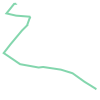

In [14]:
print(wkt[0])
linestr_obj[0]

,geometry
0,POINT (-8.61864 41.14141)
1,POINT (-8.61850 41.14138)
2,POINT (-8.62033 41.14251)
3,POINT (-8.62215 41.14381)
4,POINT (-8.62395 41.14437)


<AxesSubplot:>

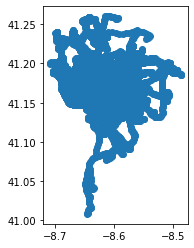

In [15]:
gpoints = gpd.GeoDataFrame([{'geometry': p} for p in allpoints], crs=crs)             
display(gpoints.head())
gpoints.plot()

<AxesSubplot:>

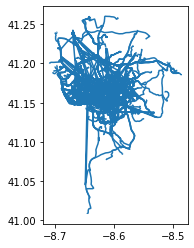

In [38]:
gls = gpd.GeoDataFrame([{'geometry': ls} for ls in linestr_obj], crs=crs)  
# display(gls.head())
gls.plot()

In [40]:
#https://anitagraser.com/2019/10/31/interactive-plots-for-geopandas-geodataframe-of-linestrings/
m = folium.Map([porto_lat, porto_lon], zoom_start=12, zoom_control = False)
 
folium.Choropleth(
    gls,
    line_weight=2,
    line_color='blue'
).add_to(m)
 
m

In [41]:
if SAVE_IMAGES:
    img_data = m._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    img.save('all_trajectories.png')

In [19]:
# get duplicated points
duplicated_points = gpoints[gpoints.duplicated()]
display(duplicated_points)
print(f"{len(duplicated_points)} duplicated points.")

,geometry
113,POINT (-8.57471 41.15192)
272,POINT (-8.62474 41.16154)
525,POINT (-8.64798 41.16939)
526,POINT (-8.64798 41.16939)
527,POINT (-8.64798 41.16939)
...,...
47201,POINT (-8.60407 41.18260)
47204,POINT (-8.60406 41.18256)
47210,POINT (-8.60632 41.14819)
47230,POINT (-8.59907 41.14809)


1516 duplicated points.


In [20]:
gpoints['geometry'][0].xy

(array('d', [-8.618643]), array('d', [41.141412]))

In [52]:
ftiles = ['OpenStreetMap','Stamen Terrain','Stamen Toner']
for fi in range(len(ftiles)):
    pm = folium.Map([porto_lat, porto_lon], zoom_start=14, tiles=ftiles[fi], width=500, height=500, zoom_control = False)
    folium.Marker([gpoints['geometry'][0].y, gpoints['geometry'][0].x]).add_to(pm)
    # folium.Circle([gpoints['geometry'][1].y, gpoints['geometry'][1].x], radius=10, color='crimson', fill=True, fill_color='crimson').add_to(pm)
    if SAVE_IMAGES:
        img_data = pm._to_png(5)
        img = Image.open(io.BytesIO(img_data))
        img.save(f'tile{fi}.png')

In [22]:
def coords(geom):
    return list((y, x) for x, y in geom.coords)
lcoords = gls.apply(lambda row: coords(row.geometry), axis=1)
# display(gls['geometry'][0].coords)
lcoords

0      [(41.141412, -8.618643), (41.141376, -8.618499...
1      [(41.159826, -8.639847), (41.159871, -8.640351...
2      [(41.140359, -8.612964), (41.14035, -8.613378)...
3      [(41.151951, -8.574678), (41.151942, -8.574705...
4      [(41.18049, -8.645994), (41.180517, -8.645949)...
                             ...                        
985    [(41.143113, -8.611398), (41.143167, -8.610714...
986    [(41.161023, -8.628984), (41.160996, -8.628894...
987    [(41.148531, -8.585775), (41.14863, -8.58582),...
988    [(41.147955, -8.606601), (41.14791, -8.606457)...
989    [(41.182704, -8.600112), (41.182704, -8.599743...
Length: 990, dtype: object

In [23]:
pm = folium.Map([porto_lat, porto_lon], zoom_start=15, tiles=ftiles[0])
folium.PolyLine(lcoords[0]).add_to(pm)
pm

In [24]:
pm = folium.Map([porto_lat, porto_lon], zoom_start=15, tiles=ftiles[1])
feature_group = folium.FeatureGroup("Locations")
for p in lcoords[0]:
#     feature_group.add_child(folium.Marker(location=p))
    feature_group.add_child(folium.Circle(p, radius=15, color='crimson', fill=False, fill_color='crimson'))
    
pm.add_child(feature_group)    

pm

In [25]:
import random

import matplotlib.pyplot as plt 
def generate_colors(n): 
    rgb_values = [] 
    hex_values = [] 
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256) 
    step = 256 / n 
    for _ in range(n): 
        r += step 
        g += step 
        b += step 
        r = int(r) % 256 
        g = int(g) % 256 
        b = int(b) % 256 
        r_hex = hex(r)[2:] 
        g_hex = hex(g)[2:] 
        b_hex = hex(b)[2:] 
        hex_values.append('#' + r_hex + g_hex + b_hex) 
        rgb_values.append((r,g,b)) 
    return rgb_values, hex_values

_, colors_list = generate_colors(10) 
colors_list

['#6c1e2b',
 '#853744',
 '#9e505d',
 '#b76976',
 '#d0828f',
 '#e99ba8',
 '#2b4c1',
 '#1bcdda',
 '#34e6f3',
 '#4dffc']

In [30]:
# from matplotlib import colors as mcolors
# colors_list = list(mcolors._colors_full_map.values())
# https://github.com/python-visualization/folium/blob/8ac5eb6d35940c47ea8ae194784c2b4ed4f53489/tests/test_vector_layers.py
colors_list = ['red', 'blue', 'orange', 'yellow', 'green', 'magenta', 'pink', 'purple', 'cyan', 'olive']

fmap = folium.Map([porto_lat, porto_lon], zoom_start=13.4, tiles=ftiles[1])

# PLOT_LINES = True
for idx, lcoord in enumerate(lcoords[:10]):
    feature_group = folium.FeatureGroup()
    if PLOT_LINES:
        feature_group.add_child(folium.PolyLine(lcoord, color=colors_list[idx], weight=3))
    for p in lcoord:
        feature_group.add_child(folium.Circle(p, radius=30, color=colors_list[idx], fill=True, fill_color=colors_list[idx], fill_opacity=1))
    fmap.add_child(feature_group)    

fmap

In [27]:
if SAVE_IMAGES:
    img_data = fmap._to_png(5)

    img = Image.open(io.BytesIO(img_data))
    img.save('task2.png')